# NOTEBOOK FOR DEVELOPING THE SMA CROSS OVER STRATEGY

## LEFT OFF AT TP/SL/SMA SIGNALING 

UPDATING THIS NOTEBOOK TO THE MOST RECENT IMPLEMENTATION FROM yfinance_exploration.ipynb

In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [50]:
# Strategy parameters
ticker = "NVDA"
short_window = 20
long_window = 50
take_profit_pct = 0.10
stop_loss_pct = 0.05
initial_capital = 1
years = 2

In [ ]:
# 1. Download Data and format
end_date = datetime.today()
start_date = end_date - timedelta(days=365 * years)

df_sma = yf.download(ticker, start=start_date, end=end_date)

df_sma.columns = df_sma.columns.get_level_values(0)

C:\Users\nic\AppData\Local\Temp\ipykernel_1172\3695773151.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [ ]:
# 2. Calculate SMA + signal
df_sma[f'SMA_{short_window}'] = df_sma['Close'].rolling(window=short_window).mean()
df_sma[f'SMA_{long_window}'] = df_sma['Close'].rolling(window=long_window).mean()

# Signal: 1 for long entry, -1 for short, 0 otherwise
df_sma['Signal'] = 0
df_sma.loc[df_sma[f'SMA_{short_window}'] > df_sma[f'SMA_{long_window}'], 'Signal'] = 1
df_sma.loc[df_sma[f'SMA_{short_window}'] < df_sma[f'SMA_{long_window}'], 'Signal'] = -1

# Drop early NaNs because data is only valid after enough days have passed
df_sma = df_sma.dropna().copy()

In [ ]:
# 3. TP/SL logic
tp_sl_signals = []
in_trade = False
entry_price = 0

for i in range(len(df_sma)):
    
    close_price = df_sma['Close'].iloc[i]
    
    if not in_trade:
        
        if df_sma['Signal'].iloc[i] == 1:
            


            f  adfdffadadffdfdfdfd         entry_price = close_price
            in_trade = True
            tp_sl_signals.append(1)
        
        else:
            
            tp_sl_signals.append(0)
    else:
        current_return = (close_price - entry_price) / entry_price
        
        sma_exit = df_sma['Signal'].iloc[i] == 0
        
        if current_return >= take_profit_pct or current_return <= -stop_loss_pct or sma_exit:
            
            in_trade = False
            tp_sl_signals.append(0)
        
        else:
            
            tp_sl_signals.append(1)

df_sma['TP_SL_Signal'] = tp_sl_signals


In [ ]:
print(df_sma.columns)


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_20', 'SMA_50', 'Signal',
       'TP_SL_Signal'],
      dtype='object', name='Price')


In [ ]:
# 4. Returns
df_sma['Market Return'] = df_sma['Close'].pct_change()
df_sma['Strategy Return'] = df_sma['Market Return'] * df_sma['TP_SL_Signal'].shift(1).fillna(0)
df_sma['Cumulative Market Return'] = (1 + df_sma['Market Return'].fillna(0)).cumprod()
df_sma['Cumulative Strategy Return'] = (1 + df_sma['Strategy Return']).cumprod()

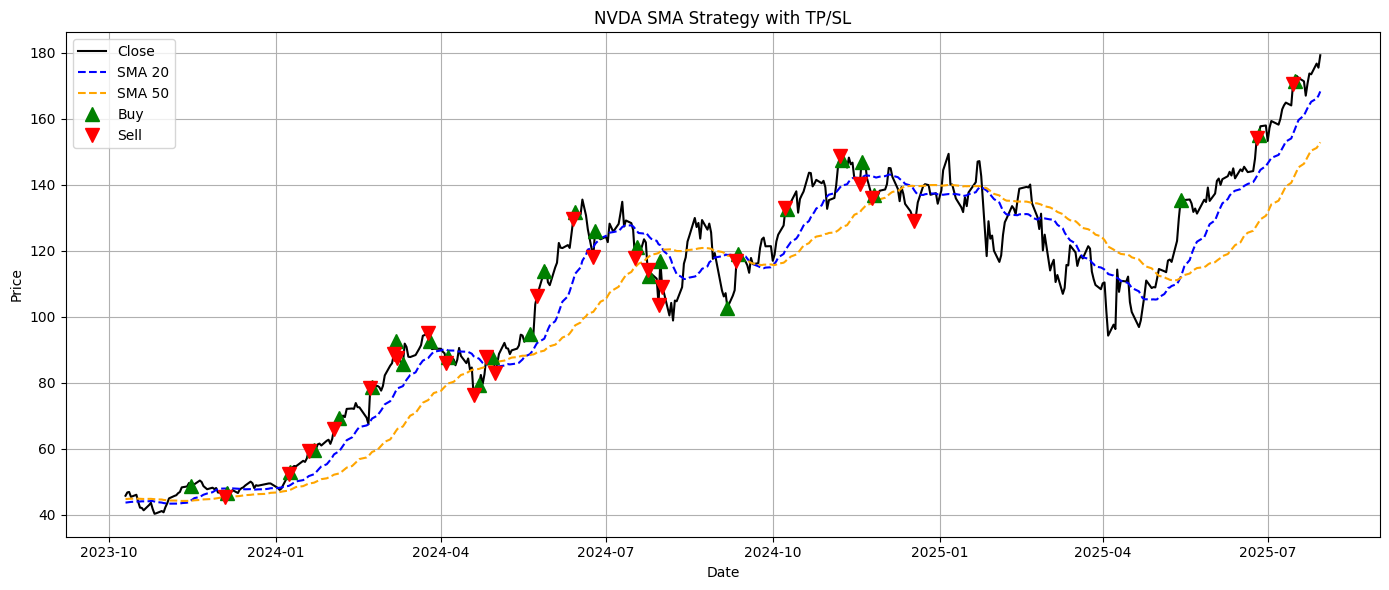

In [ ]:
# 5. Price Chart + Signals
plt.figure(figsize=(14, 6))

# Plot closing price
plt.plot(df_sma['Close'], label='Close', color='black')

# Plot dynamic SMAs
plt.plot(df_sma[f'SMA_{short_window}'], label=f'SMA {short_window}', linestyle='--', color='blue')
plt.plot(df_sma[f'SMA_{long_window}'], label=f'SMA {long_window}', linestyle='--', color='orange')

# Identify entry and exit points
buy_signals = df_sma[df_sma['TP_SL_Signal'].diff() == 1]
sell_signals = df_sma[df_sma['TP_SL_Signal'].diff() == -1]

# Plot signal markers
plt.plot(buy_signals.index, buy_signals['Close'], '^', markersize=10, color='green', label='Buy')
plt.plot(sell_signals.index, sell_signals['Close'], 'v', markersize=10, color='red', label='Sell')

# Add chart formatting
plt.title(f"{ticker} SMA Strategy with TP/SL")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


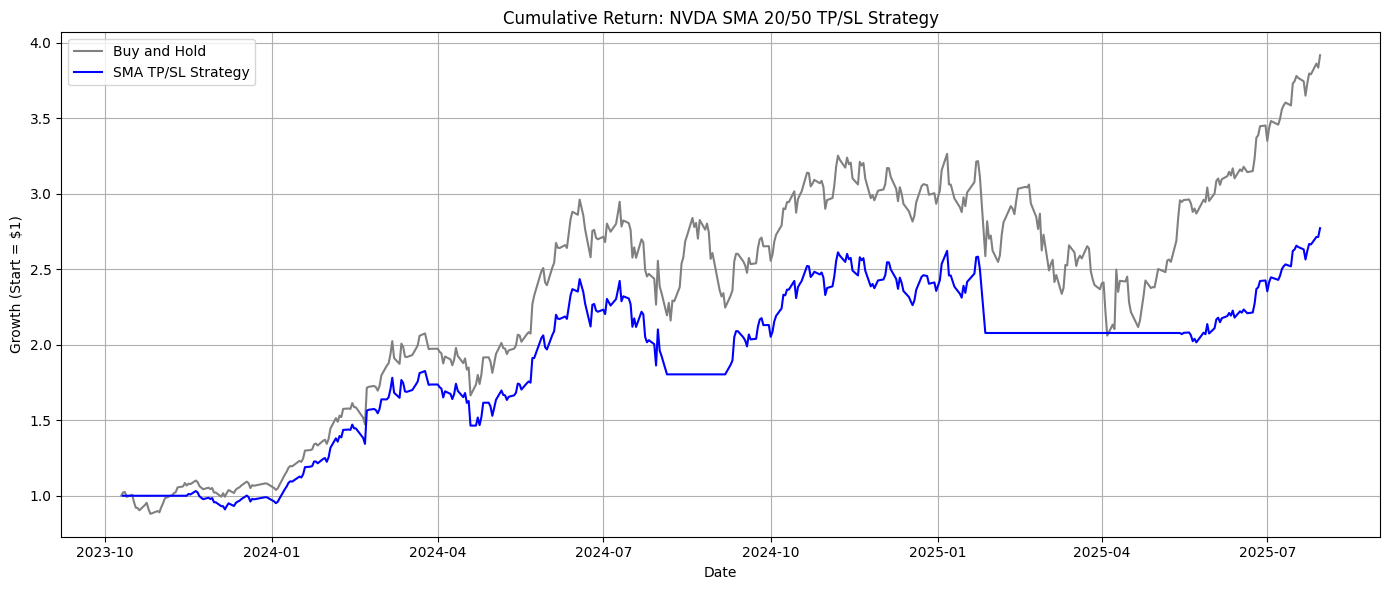

In [ ]:
# 6. Cumulative Return Chart
plt.figure(figsize=(14,6))
plt.plot(df_sma['Cumulative Market Return'], label='Buy and Hold', color='gray')
plt.plot(df_sma['Cumulative Strategy Return'], label='SMA TP/SL Strategy', color='blue')
plt.title(f'Cumulative Return: {ticker} SMA {short_window}/{long_window} TP/SL Strategy')
plt.xlabel('Date')
plt.ylabel('Growth (Start = $1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()